In [1]:
import matplotlib.pyplot as plt
import torch
import libs.as_mod as AS
import libs.fm_mod as fm
import numpy as np


### Circular Apecture

In [2]:
Nx = Ny = 120
dx = 0.5
dz = 0.5
lam = .532
mask_factor_arr = [1/2, 1/8, 1/16, 1/32, 1/64, 1/128]

Learnable transmission coefficient: Amplitude and Phase
mask factor 0.5


c:\Python311\cv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


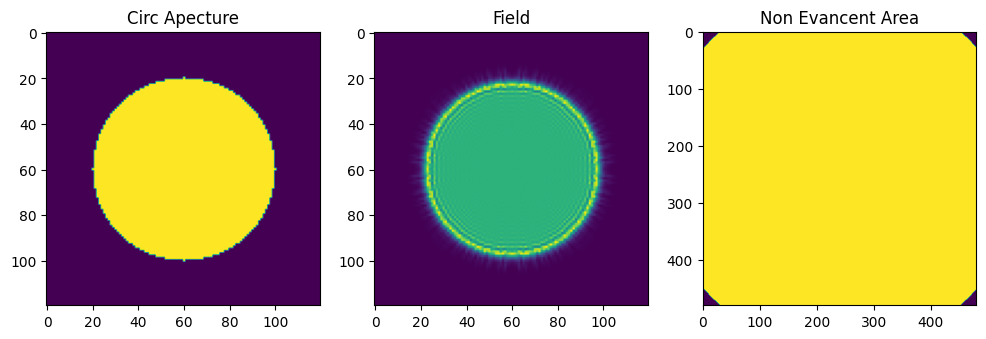

Learnable transmission coefficient: Amplitude and Phase
mask factor 0.125


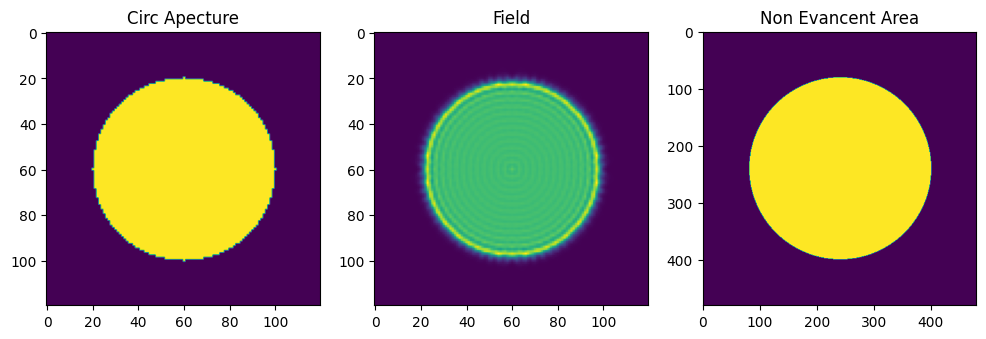

Learnable transmission coefficient: Amplitude and Phase
mask factor 0.0625


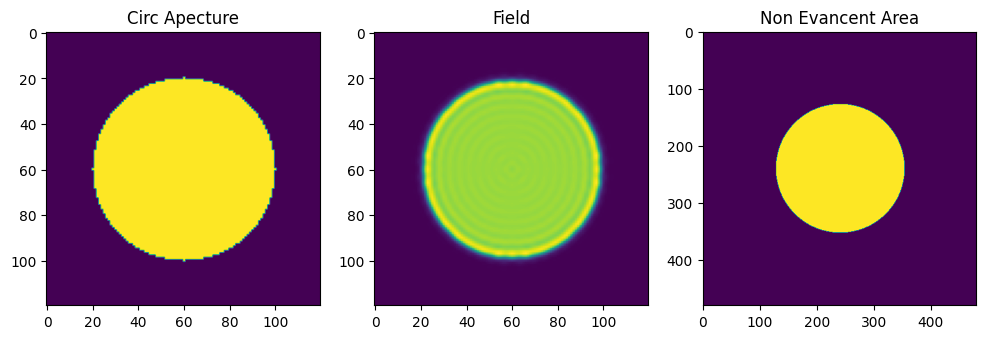

Learnable transmission coefficient: Amplitude and Phase
mask factor 0.03125


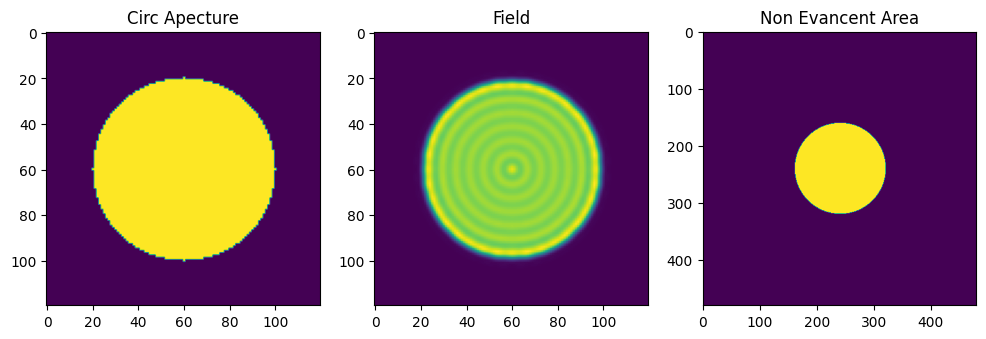

Learnable transmission coefficient: Amplitude and Phase
mask factor 0.015625


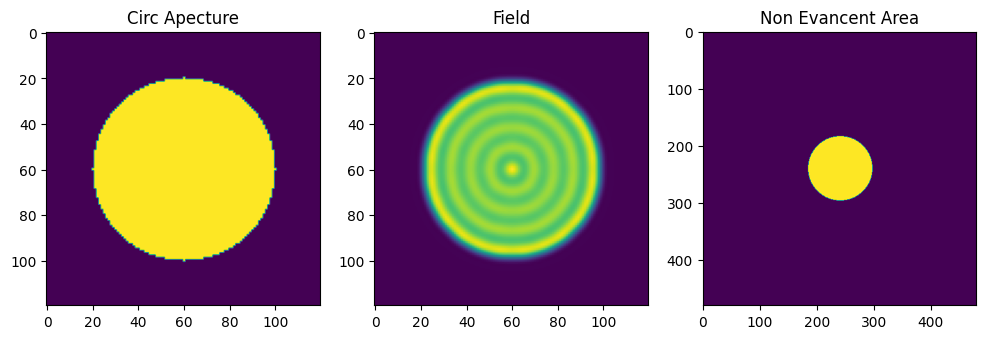

Learnable transmission coefficient: Amplitude and Phase
mask factor 0.0078125


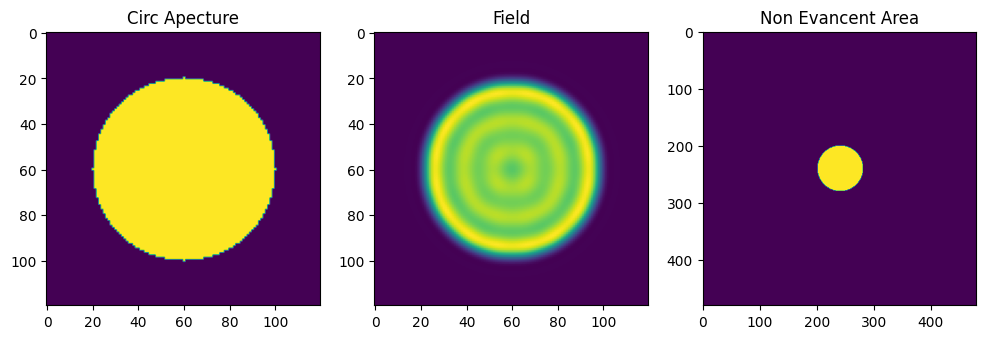

In [3]:
for m in mask_factor_arr:

    aNs = AS.d2nnASwWindow_layer(n_neurons_input = Nx, n_neurons_output=Nx, delta_z=dz, lambda_=lam, dx = dx,mask_factor=m)
    
    R , cx, cy = Nx//3, Nx//2, Ny//2
    circ_apecture = torch.zeros((Nx,Ny)).float()
    X = torch.linspace(0, Nx-1, Nx)
    Y = torch.linspace(0, Ny-1, Ny)

    x,y = torch.meshgrid(X, Y)
    distance = torch.sqrt((x - cx)**2 + (y - cy)**2 )
    in_circ = distance <= R
    circ_apecture[in_circ] = 1
    
    aNs.find_transfer_function(delta_z = 10 * dz, mask_factor=m)

    output_field = aNs.forward(circ_apecture.unsqueeze(0).float())
    field = (output_field.abs()**2).detach()
    print('mask factor',m)
    fig, axes = plt.subplots(1,3, figsize=(12, 6))

    axes[0].imshow(circ_apecture)
    axes[0].set_title("Circ Apecture")
    axes[1].imshow(field[0])
    axes[1].set_title("Field")
    axes[2].imshow(AS.non_evancent_area)
    axes[2].set_title("Non Evancent Area")
    plt.show()

### Verification

In [4]:
# Parameter Definition
NA = [1,0.8,0.6,0.4,0.2]
Rindex= 1
Nx = Ny = 120
Nz = 10
dx = 0.5
dy = 0.5
dz = 0.5
lam = .532
mask_factor_arr = [1/2, 1/8, 1/16, 1/32, 1/64, 1/128]

ep_dx = 5
ep_dy = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Sucessfully Initialized Point Spread Function...!!!


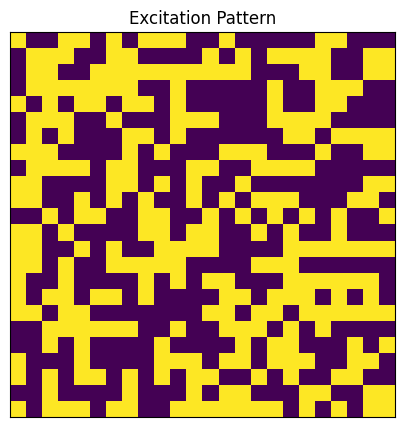

In [6]:
fm.init_parameters(NA_=NA[0], Rindex_=Rindex, lambda_=lam, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz, ep_dx_ = ep_dx, ep_dy_ = ep_dy )
fm.init_DMD(ep_dx__= ep_dx, ep_dy__=ep_dy, verbose=True)

In [ ]:

aNs = AS.d2nnASwWindow_layer(n_neurons_input = Nx, n_neurons_output=Nx, delta_z= dz, lambda_=lam, neuron_size = dx,mask_factor=m)

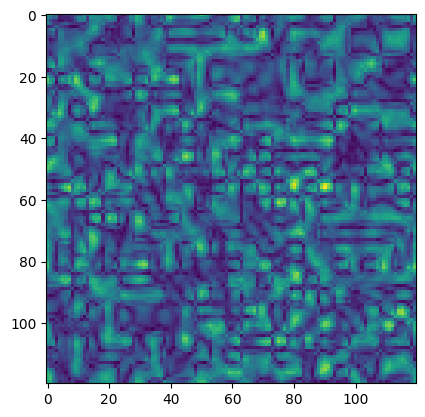

In [7]:
# Field Via Debye Theory
ht_3D = torch.zeros(1, Nz, Nx, Ny).float().to(device)
ht_3D[:, Nz // 2] = fm.ht_2D
debye_result = fm.conv_3D(fm.exPSF_3D, ht_3D).sum(dim=0).to('cpu')
plt.imshow(debye_result[5].abs())
plt.show()

In [13]:
# Field Via Angular Spectrum Method

as_result = torch.zeros(Nz, Nx,Ny, dtype=torch.complex64)

for m in mask_factor_arr:
    fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz, ep_dx_ = ep_dx, ep_dy_ = ep_dy )
    fm.init_DMD(ep_dx__= ep_dx, ep_dy__=ep_dy)
    aNs = AS.d2nnASwWindow_layer(n_neurons_input = Nx, n_neurons_output=Nx, delta_z= dz, lambda_=lambda_, neuron_size = dx,mask_factor=m)

    for i in range(-Nz//2, Nz//2+1):
        aNs.find_transfer_function(dz*i,mask_factor=m)
        output_field = aNs.forward(fm.ht_2D.unsqueeze(0))
        field = (output_field.abs()**2).detach()
        as_result[i+Nz//2] = output_field

        if (i==0):

            fig, axes = plt.subplots(1,3, figsize=(12, 6))

            axes[0].imshow(fm.ht_2D)
            axes[0].set_title("Excitation Pattern")
            axes[1].imshow(field[0])
            axes[1].set_title(f"Field at (z={i})")
            axes[2].imshow(AS.non_evancent_area)
            axes[2].set_title("Non Evancent Area")
            plt.show()

AttributeError: module 'libs.fm_mod' has no attribute 'ht_2D'

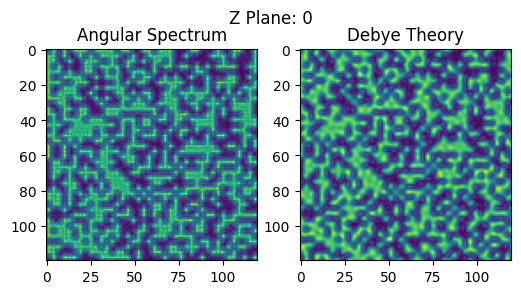

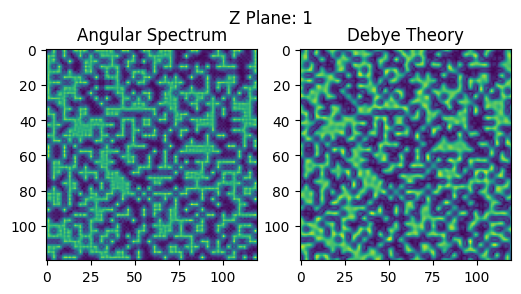

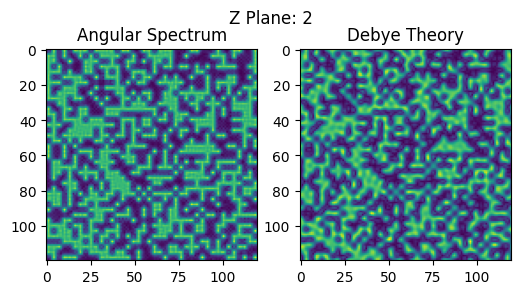

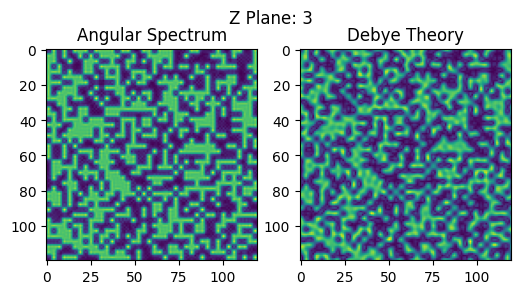

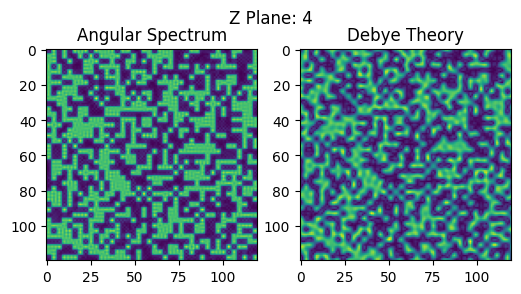

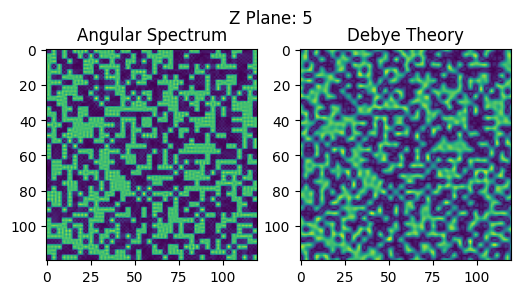

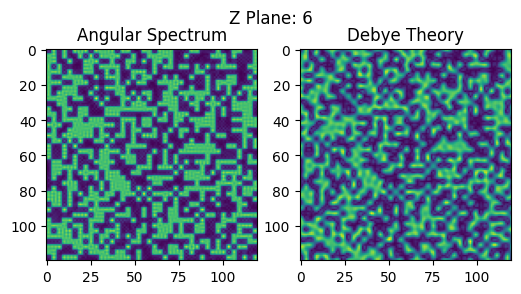

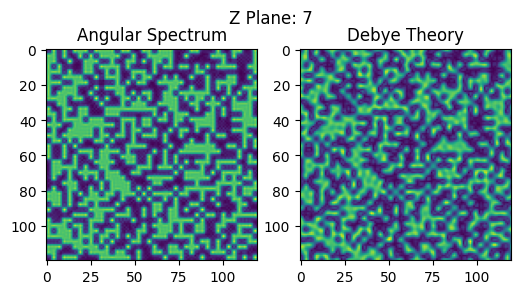

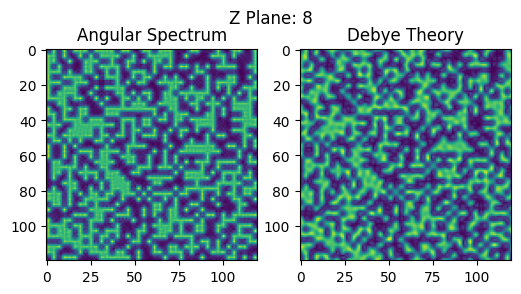

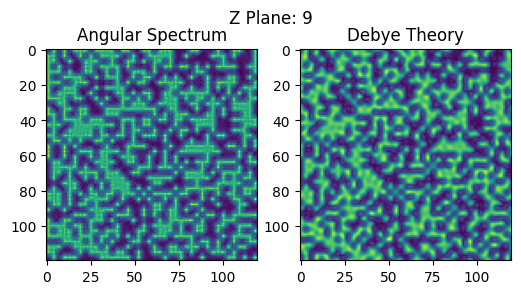

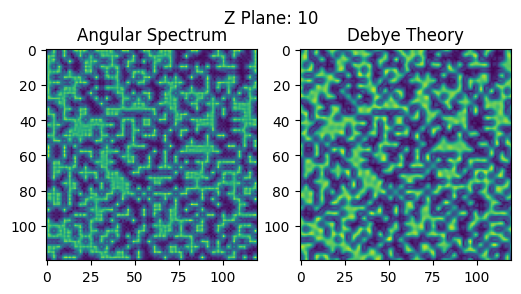

In [17]:
# Field Comparision
for i in range( Nz):
    fig, axes = plt.subplots(1,2, figsize=(6, 3))
    fig.suptitle(f"Z Plane: {i}")
    axes[0].imshow(as_result[i].abs().detach())
    axes[0].set_title("Angular Spectrum")
    axes[1].imshow(debye_result[i].abs())
    axes[1].set_title("Debye Theory")
    as_result[2]
    plt.show()